# Synthetic Dataset: k-Stability Experiments
Experiments to show that there exist features that are k-unstable.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import time

## Construct Dataset
We construct the synthetic dataset outlined in the paper, on page 10, Theorem 4.5 and Construction 4.6. We let the dataset have $n = 1000$ rows and $p = 100000$ features, for $X \in \mathbb{R}^{1000 \times 100000}$. Then, let $W$ be a noise vector sampled from $\mathcal{N}(0, \sigma^2)^{n \times 1}$ with $\sigma = 1/4$. Let $\theta^* \in [0,1]^{100000}$ be the optimal parameter vector with the first $s = 5$ coordinates with non-zero values and the last $p - s = 99995$ coordinates equal to 0. With these parameters, set the target variables to be $Y = X\theta^* + W$. 

Finally, we let $X$ be sampled from $\mathcal{N}(0,1/4)^{n \times p}$ and setting the last coordinate to 0. That is:

$$X = \left[ {\begin{array}{cccc}
   \mathcal{N}(0,1/4) & \dots & \mathcal{N}(0,1/4) & \dots & 0 \\
   \vdots & \ddots & \vdots & \ddots & \vdots \\
   \mathcal{N}(0,1/4) & \dots & \mathcal{N}(0,1/4) & \dots & 0 \\
  \end{array} } 
  \right]
$$

In [2]:
np.random.seed(6)
n = 1000
p = 100000
s = 5
sigma = 0.25 # for the noise vector
sigma_X = 0.5 # for the normal distribution

W = np.random.normal(0, sigma, n)
theta_nonzero = np.random.uniform(0.75, 1, s)
theta_zero = np.zeros(p-s)
theta = np.concatenate((theta_nonzero, theta_zero))
X = np.random.normal(0, sigma_X, (n, p))
X[:, p - 1] = 0
y = X @ theta + W

print(W[:10])
print(theta[:5])
print(theta[s:s+5])
print(X[:5])
print(y[:5])

lambd = 4 * sigma * (np.sqrt(n * np.log(p)))
#print("Lambda={}".format(lambd))

alpha = (lambd)/n
lasso = Lasso(alpha=alpha) # default: alpha = 1.0
lasso_coef = lasso.fit(X, y).coef_
print(np.where(lasso_coef > 0)[0])
print("Number of positive nonzero entries at alpha={}: {}".format(alpha, len(lasso_coef[lasso_coef > 0])))

[-0.07794592  0.18225098  0.0544552  -0.22477295 -0.62169516  0.22831288
  0.28176593 -0.37852331  0.40982277 -0.1074734 ]
[0.75376882 0.80255663 0.86653606 0.80039049 0.98363127]
[0. 0. 0. 0. 0.]
[[ 0.77345142  1.20656439 -0.86849201 ... -0.48465652 -0.29722316
   0.        ]
 [-0.28577993  0.13340248 -0.83750541 ... -0.22657422 -0.50031857
   0.        ]
 [ 0.38403514  0.66539913  0.10312353 ... -0.50733859 -0.14471365
   0.        ]
 [ 0.13843707 -0.34111937 -0.53270099 ...  0.06285148  0.74064039
   0.        ]
 [ 0.39987563  0.36095811 -0.9048938  ...  0.25997404  0.84526554
   0.        ]]
[ 0.71686065  0.20370945  0.06772799 -0.22288691 -0.01380799]
[0 1 2 3 4]
Number of positive nonzero entries at alpha=0.10729830131446737: 5


In [3]:
# Must be true for our theorem to hold
assert(n >= s * np.log(p) + np.power(s,4))
print(s * np.log(p) + np.power(s,4))

682.5646273248511


## LASSO Model
We use Lasso Regression to find the k-unstable features. Following optimization problem:

$$\min_{\theta} \frac{1}{n} \cdot \|Y - X\theta|_2^2 + \frac{2\lambda}{n} \cdot \|\theta\|_1$$

Because Lasso induces sparsity on the resulting $\theta$ vector of the model (typically used for feature selection), we find all the features that get set to 0, and call this our "target set." We aim to loop through the features in our "target set" and find the smallest value of $k$ (the number of poison rows) that adds that specific feature to $\theta$. 

sklearn's implementation of LASSO, that we're using here, is the following equivalent optimization problem, with hyperparameter $\alpha$:

$$\min_{\theta} \frac{1}{2n} \|Y - X \theta\|_2^2 + \alpha \|\theta\|_1$$

In [4]:
alpha = (lambd)/n
lasso = Lasso(alpha=alpha) # default: alpha = 1.0
lasso_coef = lasso.fit(X, y).coef_
print(np.where(lasso_coef > 0)[0])
print("Number of positive nonzero entries at alpha={}: {}".format(alpha, len(lasso_coef[lasso_coef > 0])))

[0 1 2 3 4]
Number of positive nonzero entries at alpha=0.10729830131446737: 5


In [5]:
# Initialize the support and set of poisoning targets
support = np.where(lasso_coef > 0)[0]
target_set = np.where(lasso_coef <= 0)[0]
print(target_set[:10])
print(len(target_set))

[ 5  6  7  8  9 10 11 12 13 14]
99995


### Poisoning Attack
We follow the poisoning attack proposed in **Theorem 4.5** and **Construction 4.6**. That is, for some $k$, the number of posion rows, we generate:

$$X_p = \left[ {\begin{array}{cccc}
   0 & \dots & 1 & \dots & 0 \\
   \vdots & \ddots & \vdots & \ddots & \vdots \\
   0 & \dots & 1 & \dots & 0 \\
  \end{array} } 
  \right]
$$

for the features of our attack, and 

$$Y_p = \left[ {\begin{array}{c}
   1 \\
   \vdots \\
   1
  \end{array} } 
  \right]
$$

for the outcome variable of our attack. Then, for $X_0$ and $Y_0$ our original dataset, we append the poison rows $X_p$ and $Y_p$ to get:

$$\left[ {\begin{array}{c|c}
   X_0 & Y_0 \\
   X_p & Y_p \\
  \end{array} } 
  \right]
$$

In [6]:
# takes the number of rows to poison, fits a LASSO on the poisoned dataset
def poisoned_lasso(lambd, target, poison_rows, X, y): 
    # Generate poison vectors
    X_poison = np.zeros(shape=(poison_rows, len(X[0])))
    X_poison[:, target] += 1 # switch last column to 1's
    y_poison = np.ones(poison_rows)        

    # Poisoned datasets
    X_poisoned = np.vstack([X, X_poison])
    y_poisoned = np.append(y, y_poison)
    
    # Alpha depends on the number of extra poison rows you add
    alpha = lambd/(len(X) + poison_rows)
    
    lasso = Lasso(alpha=alpha)
    poisoned_lasso = lasso.fit(X_poisoned,y_poisoned)
    return poisoned_lasso.coef_[target], poisoned_lasso.coef_

def plot_features_k(target_k_dict):
    mean_k = np.asarray(list(target_k_dict.values())).mean()
    plt.figure(figsize=(20, 3))
    
    # Set color of feature 99,999
    colors = []
    for feature in target_k_dict.keys():
        if(feature == 99999):
            colors.append("r")
        else:
            colors.append("c")
    
    plt.bar(range(len(target_k_dict)), list(target_k_dict.values()), align='center', color=colors)
    x_ticks = []
    for key in list(target_k_dict.keys()):
        x_ticks.append(str(key))
    plt.xticks(range(len(target_k_dict)), x_ticks, rotation=90)
    plt.axhline(y=mean_k,linewidth=1, color='r')
    plt.xlabel("Feature")
    plt.ylabel("Minimum Poison Rows to add to Theta")
    plt.show()

### Experiment Setup 

In [7]:
# take a random subset of the target set features
subsets_dict = dict()
for seed in range(5):
    np.random.seed(seed)
    subset_targets = np.random.choice(target_set, 19, replace=False) 
    subsets_dict[seed] = subset_targets

In [8]:
# Main Loop
K_RANGE = int(np.ceil(2*lambd))
subset_to_target_k_dicts = dict()
k_values = list(range(K_RANGE))

for subset in subsets_dict:
    subset_targets = subsets_dict[subset]
    target_k_dict = dict()
    
    for target in subset_targets:
        first = 0
        last = K_RANGE - 1
        found = False
        while(first <= last and not found):
            mid = (first + last)//2
            print(mid)
            coef, _ = poisoned_lasso(lambd, target, mid, X, y)
            if(coef > 0):
                prev_coef, _ = poisoned_lasso(lambd, target, mid - 1, X, y)
                if(prev_coef <= 0):
                    found = True
                    print("FOUND! {}".format(mid))
                    target_k_dict[target] = mid
                else:
                    last = mid - 1
            else:
                first = mid + 1
                
    # find necessary poison rows for 99999 feature
    target=99999
    first = 0
    last = K_RANGE - 1
    found = False
    while(first <= last and not found):
        mid = (first + last)//2
        print(mid)
        coef, _ = poisoned_lasso(lambd, target, mid, X, y)
        if(coef > 0):
            prev_coef, _ = poisoned_lasso(lambd, target, mid - 1, X, y)
            if(prev_coef <= 0):
                found = True
                print("FOUND! {}".format(mid))
                target_k_dict[target] = mid
                poison_threshold = mid - 1
            else:
                last = mid - 1
        else:
            first = mid + 1
    
    sorted_target_k_dict = {k: v for k, v in sorted(target_k_dict.items(), key=lambda item: item[1])}
    subset_to_target_k_dicts[subset] = sorted_target_k_dict
    break

107
161
134
147
140
137
135
136
FOUND! 136
107
161
134
120
127
123
125
FOUND! 125
107
161
134
120
113
110
FOUND! 110
107
161
134
120
127
130
FOUND! 130
107
161
134
120
127
123
121
122
FOUND! 122
107
161
134
120
113
116
114
FOUND! 114
107
161
134
120
113
116
118
119
FOUND! 119
107
161
134
120
113
116
FOUND! 116
107
161
134
120
127
130
128
FOUND! 128
107
161
134
FOUND! 134
107
161
134
120
127
130
128
129
FOUND! 129
107
161
134
120
127
130
132
131
FOUND! 131
107
161
134
120
113
116
114
115
FOUND! 115
107
161
134
120
127
130
128
129
FOUND! 129
107
161
134
120
113
116
118
119
FOUND! 119
107
161
134
120
127
123
125
124
FOUND! 124
107
161
134
120
127
123
FOUND! 123
107
53
80
93
100
103
105
FOUND! 105
107
161
134
120
127
123
121
122
FOUND! 122
107
161
134
120
127
123
121
122
FOUND! 122


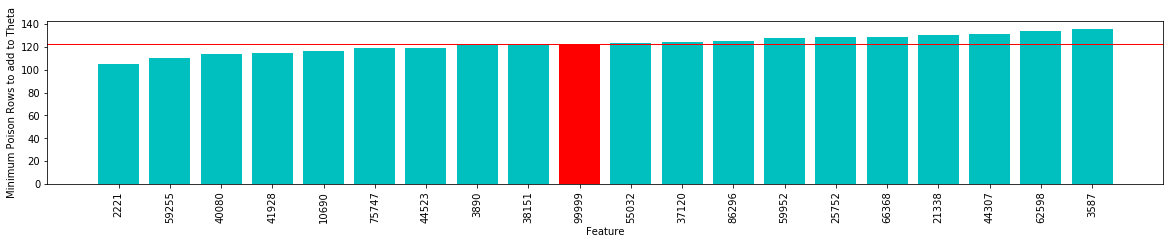

In [9]:
# Plot the results for random subset 0
plot_features_k(subset_to_target_k_dicts[0])

In [11]:
# Pickle to ploat later
import pickle
with open('synthetic_data.pkl', 'wb') as file:
    pickle.dump(sorted_target_k_dict, file)

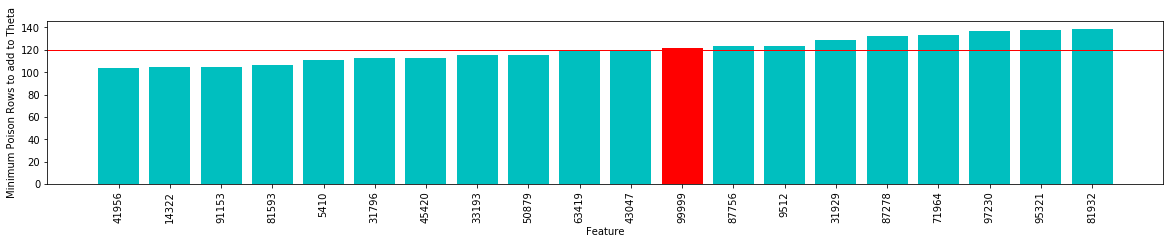

In [34]:
plot_features_k(subset_to_target_k_dicts[1])

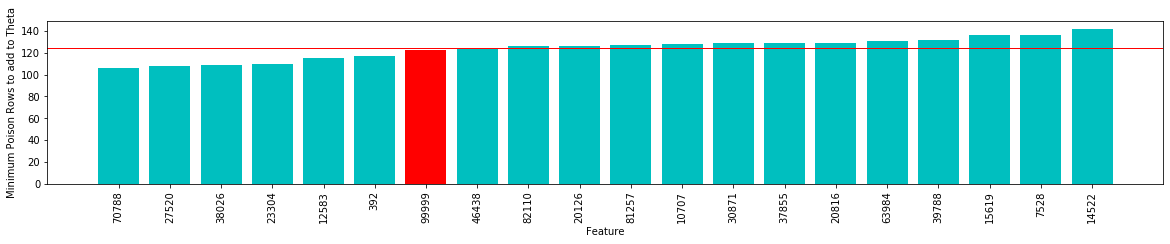

In [35]:
plot_features_k(subset_to_target_k_dicts[2])

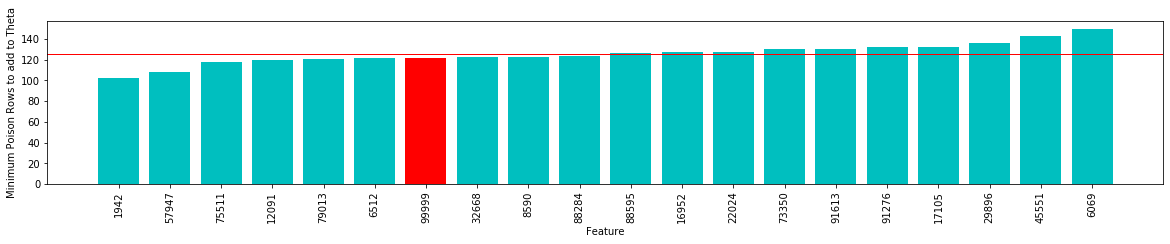

In [36]:
plot_features_k(subset_to_target_k_dicts[3])

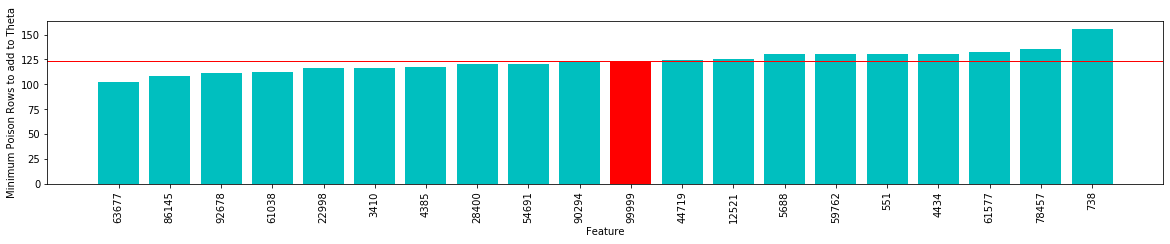

In [37]:
plot_features_k(subset_to_target_k_dicts[4])

## Poisoned Dataset

In [12]:
# Now, switch to the same experiment with the poisoned dataset
X_poison = np.zeros(shape=(poison_threshold, len(X[0])))
X_poison[:, 99999] += 1 # switch last column to 1's
y_poison = np.ones(poison_threshold)

X_poisoned = np.vstack([X, X_poison])
y_poisoned = np.append(y, y_poison)
print(X_poisoned.shape)
print(y_poisoned.shape)

(1121, 100000)
(1121,)


In [13]:
K_RANGE = int(np.ceil(2*lambd))
subset_to_target_k_dicts_poison = dict()
k_values = list(range(K_RANGE))

for subset in subsets_dict:
    subset_targets = subsets_dict[subset]
    target_k_dict = dict()
    
    for target in subset_targets:
        first = 0
        last = K_RANGE - 1
        found = False
        while(first <= last and not found):
            mid = (first + last)//2
            print(mid)
            coef, _ = poisoned_lasso(lambd, target, mid, X_poisoned, y_poisoned)
            if(coef > 0):
                prev_coef, _ = poisoned_lasso(lambd, target, mid - 1, X_poisoned, y_poisoned)
                if(prev_coef <= 0):
                    found = True
                    print("FOUND! {}".format(mid))
                    target_k_dict[target] = mid
                else:
                    last = mid - 1
            else:
                first = mid + 1
                
    # find necessary poison rows for 99999 feature
    # this should stop after 1
    for poison_rows in range(K_RANGE):
        coef, _ = poisoned_lasso(lambd, 99999, poison_rows, X_poisoned, y_poisoned)
        # Check poisoned dataset
        if(coef > 0):
            target_k_dict[99999] = poison_rows
            poison_threshold = poison_rows - 1
            break
    
    sorted_target_k_dict = {k: v for k, v in sorted(target_k_dict.items(), key=lambda item: item[1])}
    subset_to_target_k_dicts_poison[subset] = sorted_target_k_dict

107
161
134
147
154
FOUND! 154
107
161
134
147
140
143
141
FOUND! 141
107
161
134
120
127
123
FOUND! 123
107
161
134
147
140
143
145
146
FOUND! 146
107
161
134
147
140
137
135
FOUND! 135
107
161
134
120
127
130
128
129
FOUND! 129
107
161
134
120
127
130
132
131
FOUND! 131
107
161
134
120
127
130
132
131
FOUND! 131
107
161
134
147
140
143
145
FOUND! 145
107
161
134
147
154
150
148
149
FOUND! 149
107
161
134
147
140
143
145
146
FOUND! 146
107
161
134
147
FOUND! 147
107
161
134
120
127
130
128
FOUND! 128
107
161
134
147
140
143
145
146
FOUND! 146
107
161
134
147
140
137
135
136
FOUND! 136
107
161
134
147
140
137
138
139
FOUND! 139
107
161
134
147
140
137
135
136
FOUND! 136
107
161
134
120
127
123
121
122
FOUND! 122
107
161
134
147
140
137
138
FOUND! 138
107
161
134
120
FOUND! 120
107
161
134
147
154
150
148
149
FOUND! 149
107
161
134
120
113
116
118
FOUND! 118
107
161
134
147
154
157
FOUND! 157
107
161
134
147
154
157
FOUND! 157
107
161
134
120
127
123
125
126
FOUND! 126
107
161
134
120
1

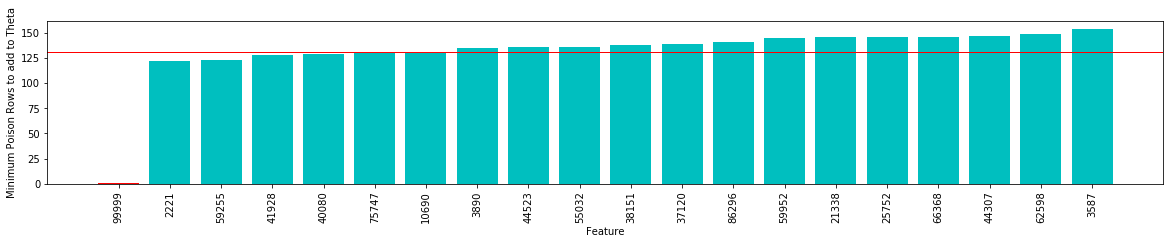

In [15]:
plot_features_k(subset_to_target_k_dicts_poison[0])

In [17]:
# Pickle to ploat later
import pickle
with open('synthetic_data.pkl', 'wb') as file:
    pickle.dump(subset_to_target_k_dicts_poison[0], file)

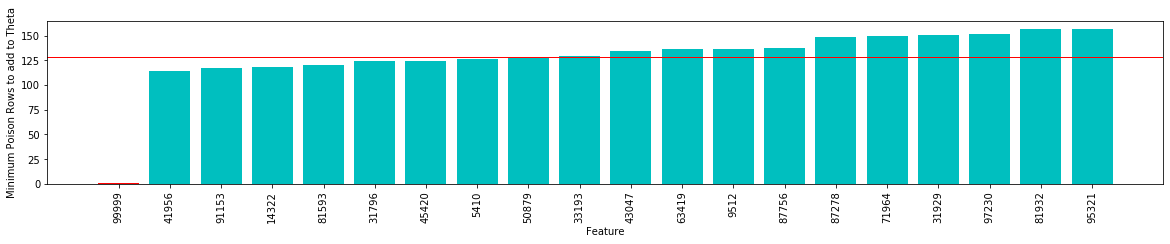

In [41]:
plot_features_k(subset_to_target_k_dicts_poison[1])

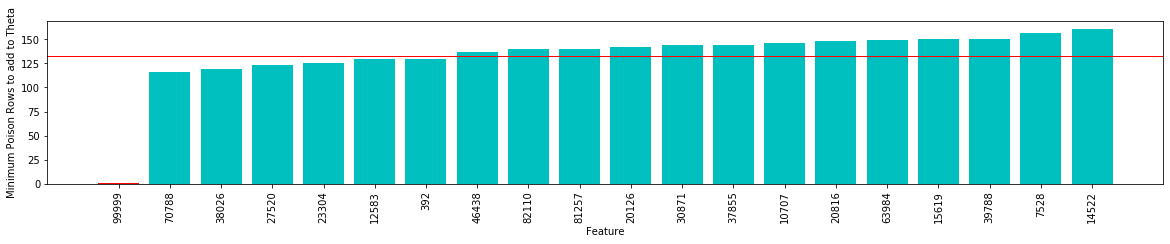

In [42]:
plot_features_k(subset_to_target_k_dicts_poison[2])

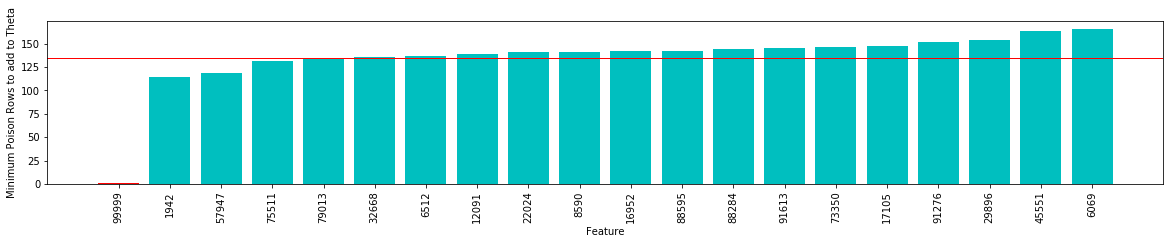

In [43]:
plot_features_k(subset_to_target_k_dicts_poison[3])

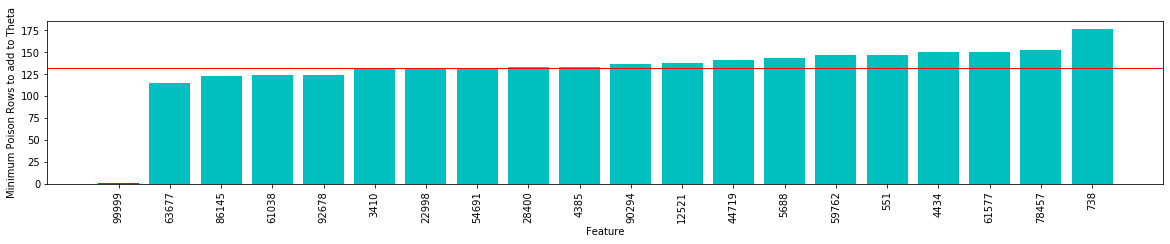

In [44]:
plot_features_k(subset_to_target_k_dicts_poison[4])

## Non-Binary Search Way (Slow)

In [18]:
# Main Loop
'''
K_RANGE = int(np.ceil(2*lambd))
subset_to_target_k_dicts = dict()

for subset in subsets_dict:
    subset_targets = subsets_dict[subset]
    target_k_dict = dict()
    
    # find necessary poison rows for non-99999 features
    for target in subset_targets:
        print(target)
        for poison_rows in range(K_RANGE):
            start_time = time.time()
            coef, _ = poisoned_lasso(lambd, target, poison_rows, X, y)
            # Check poisoned dataset
            if(coef > 0):
                target_k_dict[target] = poison_rows
                break
                
            end_time = time.time()
            print(poison_rows)
            print("Time for inner loop={}".format(end_time - start_time))  
    
    # find necessary poison rows for 99999 feature
    for poison_rows in range(K_RANGE):
        coef, _ = poisoned_lasso(lambd, 99999, poison_rows, X, y)
        # Check poisoned dataset
        if(coef > 0):
            target_k_dict[99999] = poison_rows
            poison_threshold = poison_rows - 1
            break
    
    sorted_target_k_dict = {k: v for k, v in sorted(target_k_dict.items(), key=lambda item: item[1])}
    subset_to_target_k_dicts[subset] = sorted_target_k_dict
    break
'''

'\nK_RANGE = int(np.ceil(2*lambd))\nsubset_to_target_k_dicts = dict()\n\nfor subset in subsets_dict:\n    subset_targets = subsets_dict[subset]\n    target_k_dict = dict()\n    \n    # find necessary poison rows for non-99999 features\n    for target in subset_targets:\n        print(target)\n        for poison_rows in range(K_RANGE):\n            start_time = time.time()\n            coef, _ = poisoned_lasso(lambd, target, poison_rows, X, y)\n            # Check poisoned dataset\n            if(coef > 0):\n                target_k_dict[target] = poison_rows\n                break\n                \n            end_time = time.time()\n            print(poison_rows)\n            print("Time for inner loop={}".format(end_time - start_time))  \n    \n    # find necessary poison rows for 99999 feature\n    for poison_rows in range(K_RANGE):\n        coef, _ = poisoned_lasso(lambd, 99999, poison_rows, X, y)\n        # Check poisoned dataset\n        if(coef > 0):\n            target_k_dict[